# Model Deep Learning (PyTorch dan TensorFlow) untuk Prediksi aveOralM

Dalam notebook ini, kita akan membuat model deep learning menggunakan PyTorch dan TensorFlow untuk memprediksi variabel target `aveOralM` dari dataset Infrared.

## 1. Import Library

In [1]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import math

# Import library PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Import library TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Set seed untuk reproduksibilitas
np.random.seed(42)
torch.manual_seed(42)
tf.random.set_seed(42)

## 2. Load dan Eksplorasi Data

In [2]:
# Mengunduh dataset Infrared.csv dari GitHub
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/Dataset/Infrared.csv"
response = requests.get(url)
data = StringIO(response.text)
df = pd.read_csv(data)

# Tampilkan informasi dataset
print("Informasi Dataset:")
print(df.info())
print("\nSampel Data:")
print(df.head())
print("\nStatistik Deskriptif (hanya untuk kolom numerik):")
print(df.describe())

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 34 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Gender       1020 non-null   object 
 1   Age          1020 non-null   object 
 2   Ethnicity    1020 non-null   object 
 3   T_atm        1020 non-null   float64
 4   Humidity     1020 non-null   float64
 5   Distance     1018 non-null   float64
 6   T_offset1    1020 non-null   float64
 7   Max1R13_1    1020 non-null   float64
 8   Max1L13_1    1020 non-null   float64
 9   aveAllR13_1  1020 non-null   float64
 10  aveAllL13_1  1020 non-null   float64
 11  T_RC1        1020 non-null   float64
 12  T_RC_Dry1    1020 non-null   float64
 13  T_RC_Wet1    1020 non-null   float64
 14  T_RC_Max1    1020 non-null   float64
 15  T_LC1        1020 non-null   float64
 16  T_LC_Dry1    1020 non-null   float64
 17  T_LC_Wet1    1020 non-null   float64
 18  T_LC_Max1    1020 non-null   

In [3]:
# Periksa nilai yang hilang
print("\nJumlah nilai yang hilang pada setiap kolom:")
print(df.isnull().sum())

# Mengidentifikasi kolom kategorikal dan numerik
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\nKolom kategorikal:")
print(categorical_cols)
print("\nKolom numerik:")
print(numerical_cols)

# Periksa apakah nilai NaN atau infinity dalam target
print("\nNilai NaN dalam target (aveOralM):", df['aveOralM'].isna().sum())
print("Nilai Inf dalam target (aveOralM):", np.isinf(df['aveOralM']).sum())


Jumlah nilai yang hilang pada setiap kolom:
Gender         0
Age            0
Ethnicity      0
T_atm          0
Humidity       0
Distance       2
T_offset1      0
Max1R13_1      0
Max1L13_1      0
aveAllR13_1    0
aveAllL13_1    0
T_RC1          0
T_RC_Dry1      0
T_RC_Wet1      0
T_RC_Max1      0
T_LC1          0
T_LC_Dry1      0
T_LC_Wet1      0
T_LC_Max1      0
RCC1           0
LCC1           0
canthiMax1     0
canthi4Max1    0
T_FHCC1        0
T_FHRC1        0
T_FHLC1        0
T_FHBC1        0
T_FHTC1        0
T_FH_Max1      0
T_FHC_Max1     0
T_Max1         0
T_OR1          0
T_OR_Max1      0
aveOralM       0
dtype: int64

Kolom kategorikal:
['Gender', 'Age', 'Ethnicity']

Kolom numerik:
['T_atm', 'Humidity', 'Distance', 'T_offset1', 'Max1R13_1', 'Max1L13_1', 'aveAllR13_1', 'aveAllL13_1', 'T_RC1', 'T_RC_Dry1', 'T_RC_Wet1', 'T_RC_Max1', 'T_LC1', 'T_LC_Dry1', 'T_LC_Wet1', 'T_LC_Max1', 'RCC1', 'LCC1', 'canthiMax1', 'canthi4Max1', 'T_FHCC1', 'T_FHRC1', 'T_FHLC1', 'T_FHBC1', 'T_FHTC1'

In [4]:
# Menangani nilai yang hilang dalam dataset
# Mengisi nilai yang hilang dalam kolom numerik dengan median
for col in numerical_cols:
    if df[col].isna().sum() > 0:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Mengisi {df[col].isna().sum()} nilai yang hilang dalam kolom {col} dengan median: {median_val}")

# Mengisi nilai yang hilang dalam kolom kategorikal dengan modus
for col in categorical_cols:
    if df[col].isna().sum() > 0:
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"Mengisi {df[col].isna().sum()} nilai yang hilang dalam kolom {col} dengan modus: {mode_val}")

# Verifikasi nilai yang hilang setelah imputasi
print("\nJumlah nilai yang hilang setelah imputasi:")
print(df.isnull().sum().sum())

Mengisi 0 nilai yang hilang dalam kolom Distance dengan median: 0.62

Jumlah nilai yang hilang setelah imputasi:
0


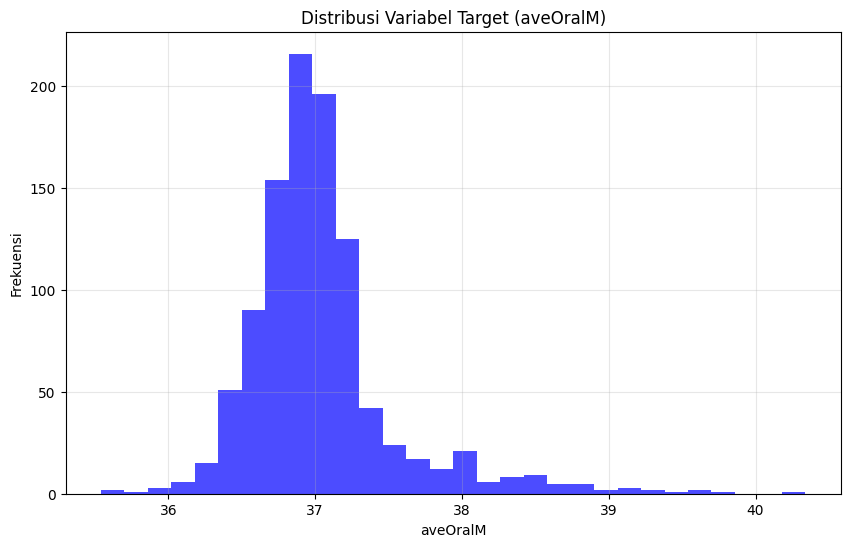

In [5]:
# Memeriksa distribusi variabel target
plt.figure(figsize=(10, 6))
plt.hist(df['aveOralM'], bins=30, alpha=0.7, color='blue')
plt.title('Distribusi Variabel Target (aveOralM)')
plt.xlabel('aveOralM')
plt.ylabel('Frekuensi')
plt.grid(True, alpha=0.3)
plt.show()

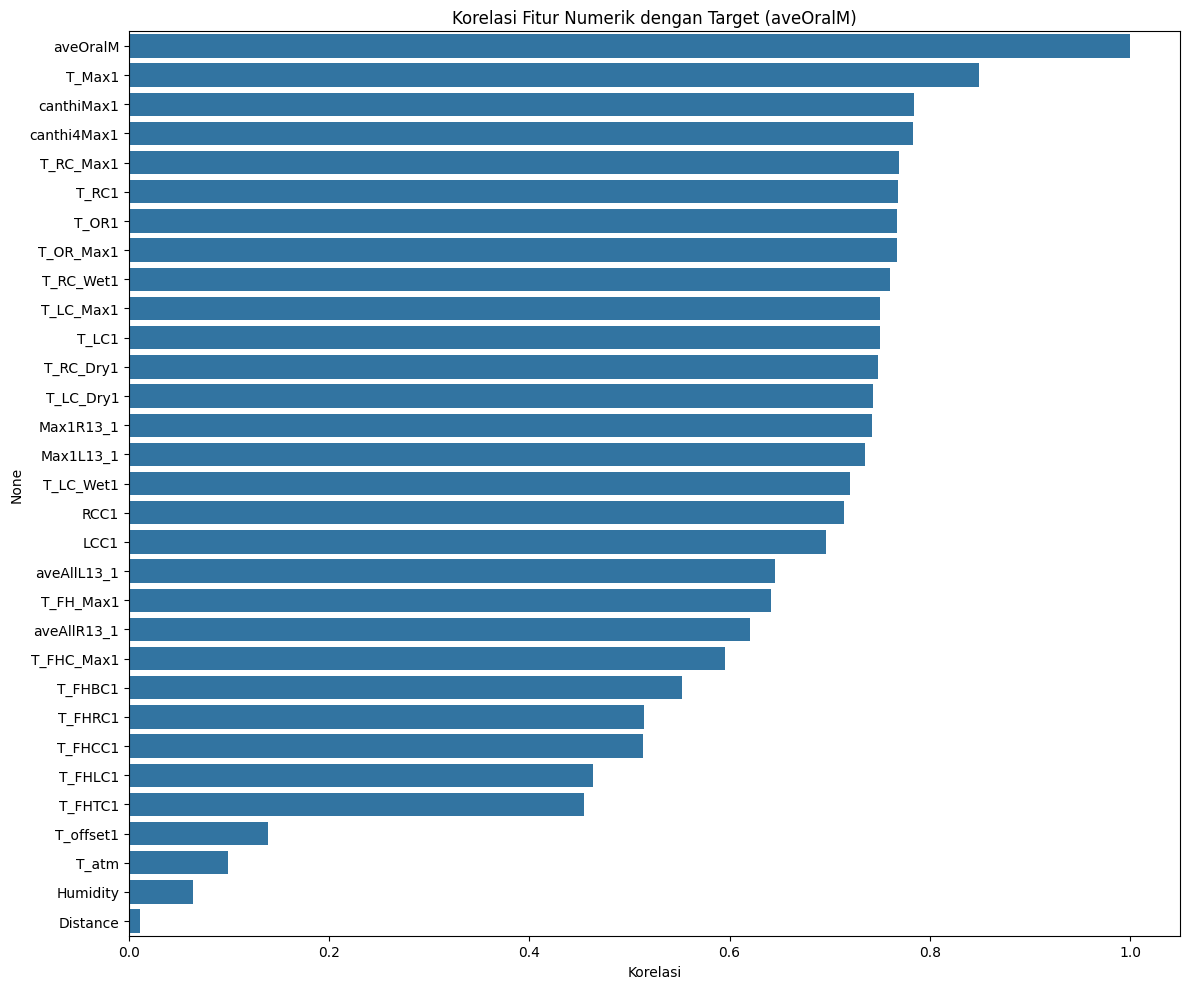

In [6]:
# Korelasi antara fitur numerik dan target
if 'aveOralM' in numerical_cols:
    plt.figure(figsize=(12, 10))
    numeric_df = df[numerical_cols].copy()
    correlation = numeric_df.corr()['aveOralM'].sort_values(ascending=False)
    sns.barplot(x=correlation.values, y=correlation.index)
    plt.title('Korelasi Fitur Numerik dengan Target (aveOralM)')
    plt.xlabel('Korelasi')
    plt.tight_layout()
    plt.show()

## 3. Preprocessing Data

In [7]:
# Pisahkan fitur dan target
X = df.drop('aveOralM', axis=1)
y = df['aveOralM']

# Mengidentifikasi kolom kategorikal dan numerik dalam X
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Membuat preprocessing pipeline dengan SimpleImputer untuk menangani NaN
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Fit dan transform data
X_processed = preprocessor.fit_transform(X)
print(f"Ukuran data setelah preprocessing: {X_processed.shape}")

# Bagi data menjadi data latih (70%) dan data uji (30%)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=42)

print(f"Ukuran data latih: {X_train.shape}, {y_train.shape}")
print(f"Ukuran data uji: {X_test.shape}, {y_test.shape}")

Ukuran data setelah preprocessing: (1020, 43)
Ukuran data latih: (714, 43), (714,)
Ukuran data uji: (306, 43), (306,)


## 4. Definisi Fungsi Evaluasi

In [8]:
def evaluate_model(y_true, y_pred, model_name):
    # Menghilangkan nilai NaN jika ada
    mask = ~np.isnan(y_pred)
    if not np.all(mask):
        print(f"Warning: Ditemukan {np.sum(~mask)} nilai NaN dalam prediksi. Nilai-nilai ini akan dihilangkan dari evaluasi.")
        y_true = y_true[mask]
        y_pred = y_pred[mask]

    # 1. Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)

    # 2. Root Mean Squared Error (RMSE)
    rmse = math.sqrt(mse)

    # 3. R-squared (R²)
    r2 = r2_score(y_true, y_pred)

    print(f"\nHasil Evaluasi Model {model_name}:")
    print(f"MSE (Mean Squared Error): {mse:.4f}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"R² (R-squared): {r2:.4f}")

    return mse, rmse, r2

## 5. Model dengan PyTorch

### 5.1 Definisi Model PyTorch

In [9]:
class DeepNetworkPyTorch(nn.Module):
    def __init__(self, input_dim):
        super(DeepNetworkPyTorch, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),  # Hidden layer 1
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),         # Hidden layer 2
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),          # Hidden layer 3
            nn.ReLU(),
            nn.Linear(32, 1)            # Output layer
        )

    def forward(self, x):
        return self.model(x)

### 5.2 Persiapan Data PyTorch

In [10]:
# Konversi data ke tensor PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1)

# Buat dataset dan dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

# Inisialisasi model
input_dim = X_train.shape[1]
model_pytorch = DeepNetworkPyTorch(input_dim)

# Definisi loss function dan optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model_pytorch.parameters(), lr=0.001)

### 5.3 Pelatihan Model PyTorch

In [11]:
def train_pytorch_model(model, train_loader, criterion, optimizer, num_epochs=100):
    losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass dan optimisasi
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        losses.append(epoch_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    return losses

# Melatih model
print("Training PyTorch Model...")
pytorch_losses = train_pytorch_model(model_pytorch, train_loader, criterion, optimizer)

Training PyTorch Model...
Epoch [10/100], Loss: 32.6251
Epoch [20/100], Loss: 16.0177
Epoch [30/100], Loss: 13.7859
Epoch [40/100], Loss: 13.3519
Epoch [50/100], Loss: 11.6286
Epoch [60/100], Loss: 11.7184
Epoch [70/100], Loss: 11.4410
Epoch [80/100], Loss: 11.0944
Epoch [90/100], Loss: 11.4527
Epoch [100/100], Loss: 10.2127


### 5.4 Evaluasi Model PyTorch


Hasil Evaluasi Model PyTorch:
MSE (Mean Squared Error): 7.1181
RMSE (Root Mean Squared Error): 2.6680
R² (R-squared): -24.5581


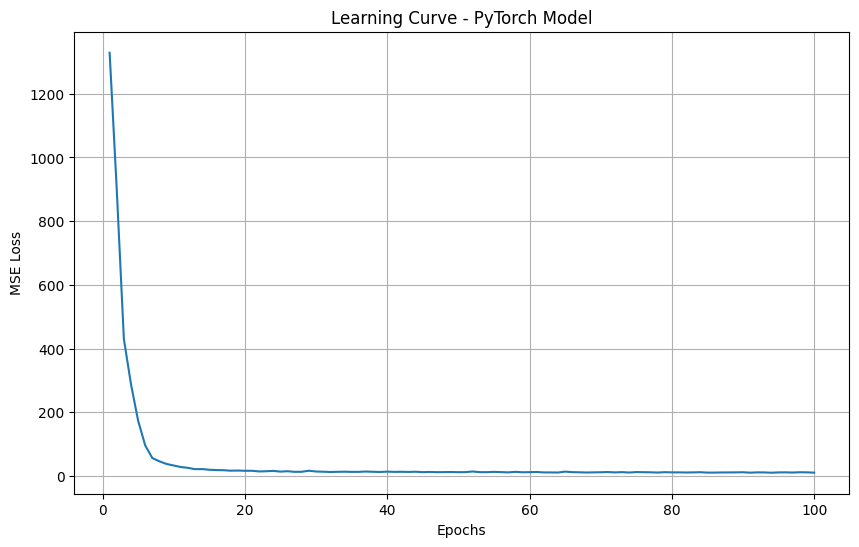

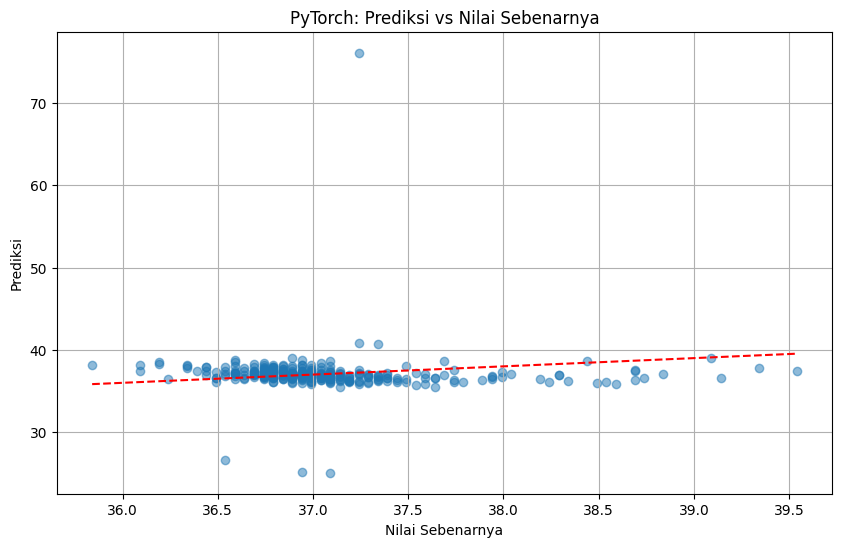

In [12]:
# Evaluasi model
model_pytorch.eval()
with torch.no_grad():
    y_pred_pytorch = model_pytorch(X_test_tensor)
    y_pred_pytorch = y_pred_pytorch.numpy().flatten()

# Periksa dan atasi nilai NaN atau infinity dalam prediksi
nan_mask = np.isnan(y_pred_pytorch)
inf_mask = np.isinf(y_pred_pytorch)
if nan_mask.any() or inf_mask.any():
    print(f"Warning: Ditemukan {nan_mask.sum()} nilai NaN dan {inf_mask.sum()} nilai infinity dalam prediksi PyTorch.")
    # Mengganti nilai NaN dan infinity dengan rata-rata prediksi
    valid_preds = y_pred_pytorch[~(nan_mask | inf_mask)]
    if len(valid_preds) > 0:
        mean_pred = np.mean(valid_preds)
        y_pred_pytorch[nan_mask | inf_mask] = mean_pred
        print(f"Nilai-nilai tersebut telah diganti dengan mean: {mean_pred:.4f}")
    else:
        print("Semua prediksi adalah NaN atau infinity. Model mungkin tidak konvergen.")
        y_pred_pytorch = np.zeros_like(y_pred_pytorch)

# Hitung metrik evaluasi
mse_pytorch, rmse_pytorch, r2_pytorch = evaluate_model(y_test, y_pred_pytorch, "PyTorch")

# Plot kurva pembelajaran
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pytorch_losses) + 1), pytorch_losses)
plt.title('Learning Curve - PyTorch Model')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

# Plot prediksi vs nilai sebenarnya
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_pytorch, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Nilai Sebenarnya')
plt.ylabel('Prediksi')
plt.title('PyTorch: Prediksi vs Nilai Sebenarnya')
plt.grid(True)
plt.show()

## 6. Model dengan TensorFlow

### 6.1 Definisi Model TensorFlow

In [13]:
def create_tensorflow_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),  # Hidden layer 1
        Dropout(0.2),
        Dense(64, activation='relu'),                            # Hidden layer 2
        Dropout(0.2),
        Dense(32, activation='relu'),                            # Hidden layer 3
        Dense(1)                                                # Output layer
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Inisialisasi model TensorFlow
model_tensorflow = create_tensorflow_model(input_dim)

# Tampilkan ringkasan model
model_tensorflow.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,001 (62.50 KB)

 Trainable params: 16,001 (62.50 KB)

 Non-trainable params: 0 (0.00 B)

### 6.2 Pelatihan Model TensorFlow

In [14]:
# Melatih model
print("Training TensorFlow Model...")

# Callback untuk early stopping jika model tidak konvergen
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model_tensorflow.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Training TensorFlow Model...
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 1288.7498 - mae: 35.8709 - val_loss: 1026.2006 - val_mae: 31.8769
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 872.4979 - mae: 28.9317 - val_loss: 427.5772 - val_mae: 18.6522
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 426.9236 - mae: 17.9673 - val_loss: 333.0220 - val_mae: 15.1136
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 310.6781 - mae: 15.7080 - val_loss: 203.2727 - val_mae: 11.8438
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 220.0033 - mae: 12.1553 - val_loss: 117.2366 - val_mae: 8.6857
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 130.0483 - mae: 9.0027 - val_loss: 65.9300 - val_mae: 6.4729
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 70.1113 - mae: 6.7460 - val_loss: 46.6852 - val_mae: 5.4147
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 61.0729 - mae: 6.2564 - val_loss: 38.4080 - val_mae: 4.8

### 6.3 Evaluasi Model TensorFlow

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Hasil Evaluasi Model TensorFlow:
MSE (Mean Squared Error): 6.5702
RMSE (Root Mean Squared Error): 2.5632
R² (R-squared): -22.5909


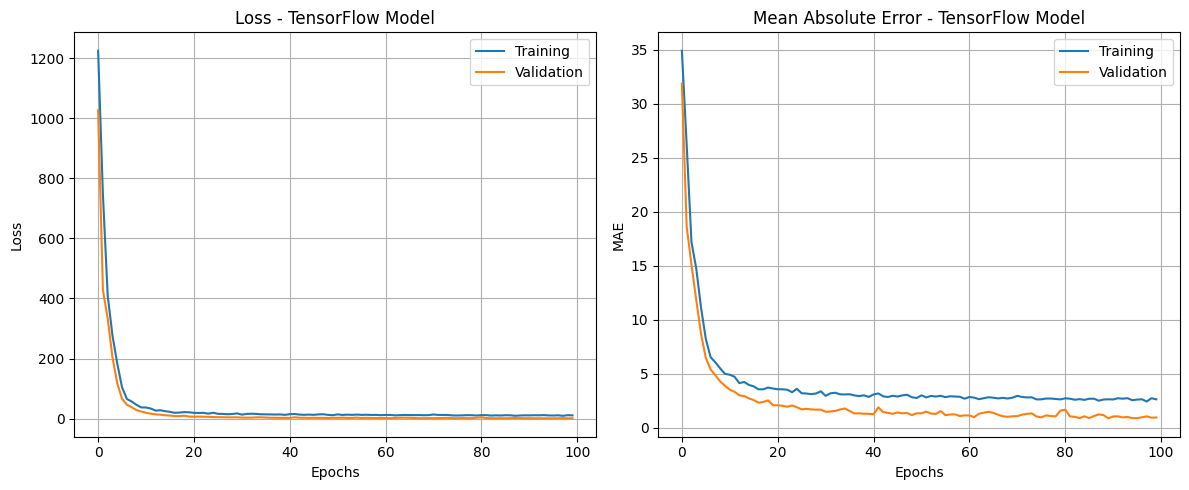

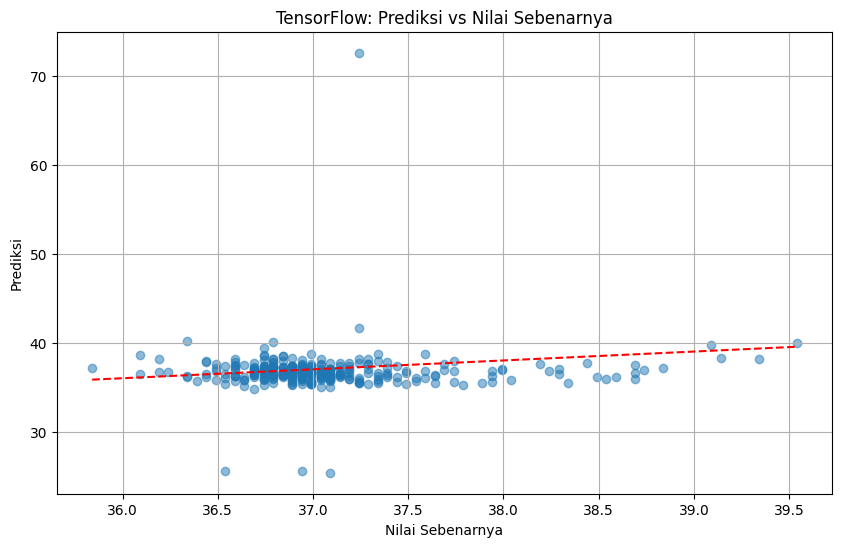

In [15]:
# Evaluasi model
y_pred_tensorflow = model_tensorflow.predict(X_test).flatten()

# Periksa dan atasi nilai NaN atau infinity dalam prediksi
nan_mask = np.isnan(y_pred_tensorflow)
inf_mask = np.isinf(y_pred_tensorflow)
if nan_mask.any() or inf_mask.any():
    print(f"Warning: Ditemukan {nan_mask.sum()} nilai NaN dan {inf_mask.sum()} nilai infinity dalam prediksi TensorFlow.")
    # Mengganti nilai NaN dan infinity dengan rata-rata prediksi
    valid_preds = y_pred_tensorflow[~(nan_mask | inf_mask)]
    if len(valid_preds) > 0:
        mean_pred = np.mean(valid_preds)
        y_pred_tensorflow[nan_mask | inf_mask] = mean_pred
        print(f"Nilai-nilai tersebut telah diganti dengan mean: {mean_pred:.4f}")
    else:
        print("Semua prediksi adalah NaN atau infinity. Model mungkin tidak konvergen.")
        y_pred_tensorflow = np.zeros_like(y_pred_tensorflow)

# Hitung metrik evaluasi
mse_tensorflow, rmse_tensorflow, r2_tensorflow = evaluate_model(y_test, y_pred_tensorflow, "TensorFlow")

# Plot kurva pembelajaran
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss - TensorFlow Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error - TensorFlow Model')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['Training', 'Validation'])
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot prediksi vs nilai sebenarnya
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_tensorflow, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Nilai Sebenarnya')
plt.ylabel('Prediksi')
plt.title('TensorFlow: Prediksi vs Nilai Sebenarnya')
plt.grid(True)
plt.show()

## 7. Perbandingan Hasil

Perbandingan Metrik Evaluasi:
  Metrik    PyTorch  TensorFlow
0    MSE   7.118086    6.570213
1   RMSE   2.667974    2.563243
2     R² -24.558091  -22.590908


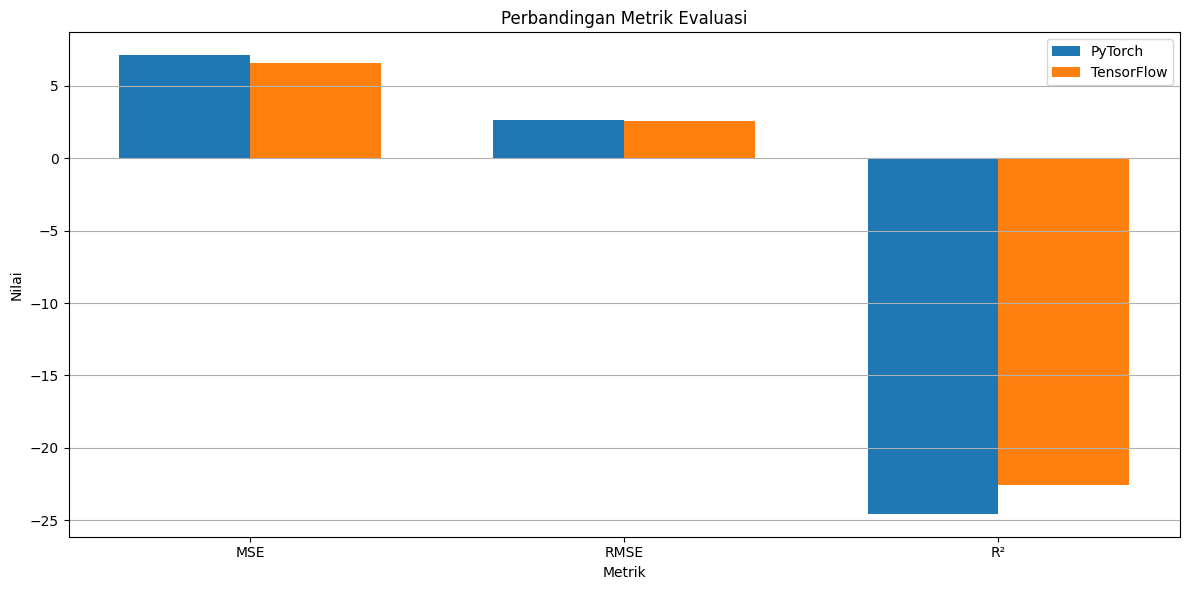

In [16]:
# Membuat DataFrame perbandingan metrik
comparison_df = pd.DataFrame({
    'Metrik': ['MSE', 'RMSE', 'R²'],
    'PyTorch': [mse_pytorch, rmse_pytorch, r2_pytorch],
    'TensorFlow': [mse_tensorflow, rmse_tensorflow, r2_tensorflow]
})

print("Perbandingan Metrik Evaluasi:")
print(comparison_df)

# Visualisasi perbandingan
metrics = ['MSE', 'RMSE', 'R²']
plt.figure(figsize=(12, 6))

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, [mse_pytorch, rmse_pytorch, r2_pytorch], width, label='PyTorch')
plt.bar(x + width/2, [mse_tensorflow, rmse_tensorflow, r2_tensorflow], width, label='TensorFlow')

plt.xlabel('Metrik')
plt.ylabel('Nilai')
plt.title('Perbandingan Metrik Evaluasi')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

## 8. Penjelasan Persamaan Matematika

### 8.1 Mean Squared Error (MSE)

MSE mengukur rata-rata dari kuadrat error, yaitu selisih antara nilai prediksi dan nilai sebenarnya.

$MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$

Dimana:
- $n$ adalah jumlah sampel dalam dataset
- $y_i$ adalah nilai sebenarnya
- $\hat{y}_i$ adalah nilai prediksi

MSE memberikan bobot yang lebih besar pada error yang lebih besar karena error dikuadratkan, sehingga sangat sensitif terhadap outlier. Nilai MSE selalu positif dan semakin rendah nilainya (mendekati nol), semakin baik modelnya.

### 8.2 Root Mean Squared Error (RMSE)

RMSE adalah akar kuadrat dari MSE. Metrik ini memiliki satuan yang sama dengan variabel target, sehingga lebih mudah diinterpretasikan.

$RMSE = \sqrt{MSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$

RMSE juga selalu positif dan semakin rendah nilainya (mendekati nol), semakin baik modelnya.

### 8.3 Coefficient of Determination (R²)

R² mengukur proporsi dari variasi variabel dependen yang dapat dijelaskan oleh variabel independen dalam model.

$R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}$

Dimana:
- $\bar{y}$ adalah rata-rata dari nilai sebenarnya

R² bernilai dari 0 hingga 1, dimana:
- R² = 1 berarti model menjelaskan semua variabilitas data
- R² = 0 berarti model tidak menjelaskan variabilitas data sama sekali
- R² < 0 dapat terjadi jika model lebih buruk daripada model garis horizontal sederhana

### 8.4 Fungsi Aktivasi ReLU (Rectified Linear Unit)

ReLU adalah fungsi aktivasi yang mengembalikan nilai input jika positif dan nol jika negatif.

$ReLU(x) = max(0, x)$

ReLU membantu mengatasi masalah vanishing gradient pada jaringan neural yang dalam dan mempercepat konvergensi pelatihan.

### 8.5 Optimasi Adam

Adam (Adaptive Moment Estimation) adalah algoritma optimasi yang menggabungkan fitur dari dua algoritma optimasi lainnya: RMSprop dan Momentum.

$m_t = \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot g_t$

$v_t = \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot g_t^2$

$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$

$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$

$\theta_t = \theta_{t-1} - \frac{\alpha}{\sqrt{\hat{v}_t} + \epsilon} \cdot \hat{m}_t$

Dimana:
- $g_t$ adalah gradien pada waktu $t$
- $m_t$ dan $v_t$ adalah momen pertama (mean) dan kedua (varian tak terpusat) dari gradien
- $\hat{m}_t$ dan $\hat{v}_t$ adalah nilai momen yang dikoreksi bias
- $\beta_1$ dan $\beta_2$ adalah hyperparameter decay rates (biasanya 0.9 dan 0.999)
- $\alpha$ adalah learning rate
- $\epsilon$ adalah konstanta kecil untuk stabilitas numerik

Adam efisien secara komputasi, memiliki kebutuhan memori yang kecil, dan cocok untuk masalah yang melibatkan data yang besar dengan banyak parameter.

### 8.6 Dropout

Dropout adalah teknik regularisasi yang mencegah overfitting dalam neural network dengan cara menonaktifkan secara acak sejumlah neuron selama pelatihan.

$P(h_i) = \begin{cases}
0 & \text{dengan probabilitas } p \\
\frac{h_i}{1-p} & \text{dengan probabilitas } 1-p
\end{cases}$

Dimana:
- $h_i$ adalah output dari neuron ke-$i$
- $p$ adalah probabilitas dropout

Dropout membantu neural network belajar fitur yang lebih robust dan mengurangi co-adaptation antar neuron.